In [26]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import seaborn as sns
# import 
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima.model import ARIMA

In [3]:
df = pd.read_excel(r'D:\MSc Software and AI\Team Project\TurbineTeamProject\data\dundalk_2020.xlsx')

In [4]:
turbine_cols = ['Pitch', 'GenRPM', 'RotorRPM', 'EnvirTemp', 'NacelTemp', 'GearOilTemp',
       'GearBearTemp', 'GenTemp', 'GenPh1Temp', 'GenPh2Temp', 'GenPh3Temp',
       'GenBearTemp']
df = df.drop(turbine_cols, axis = 1)
df.set_index(['Timestamps'], inplace= True)


In [5]:
minmax = MinMaxScaler()
df_scaled = df.copy()
df_scaled[df.columns] = minmax.fit_transform(df)

In [7]:
# train_size = int(len(df_scaled) * 0.95)

train_data = df_scaled.loc['2020-01-01':'2020-01-31']
test_data = df_scaled.loc['2020-02-01 00:00:00':'2020-02-01 08:00:00']


In [8]:
train_X, train_y = train_data[['WindSpeed']], train_data['Power']
test_X, test_y = test_data[['WindSpeed']], test_data['Power']

In [24]:
# Define SARIMAX model (ARIMA + wind speed as exogenous variable)
p=2
q=2
model = SARIMAX(train_y, exog=train_X, order=(p, 1, q))

# Fit model
model_fit = model.fit()

# Print model summary
print(model_fit.summary())


c:\Users\rsaxe\.conda\envs\yolov8\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 10min will be used.
  self._init_dates(dates, freq)
c:\Users\rsaxe\.conda\envs\yolov8\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 10min will be used.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:                  Power   No. Observations:                 4464
Model:               SARIMAX(2, 1, 2)   Log Likelihood                8051.040
Date:                Fri, 14 Feb 2025   AIC                         -16090.080
Time:                        10:42:12   BIC                         -16051.659
Sample:                    01-01-2020   HQIC                        -16076.536
                         - 01-31-2020                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
WindSpeed      1.4595      0.008    190.865      0.000       1.445       1.475
ar.L1          0.3275      0.143      2.296      0.022       0.048       0.607
ar.L2          0.3466      0.120      2.880      0.0

In [23]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
# Use actual timestamps for start and end
start_date = test_y.index[0]  # First timestamp of test data
end_date = test_y.index[-1]   # Last timestamp of test data

# Make predictions using the actual timestamps
predictions = model_fit.predict(start=start_date, end=end_date, exog=test_X)

# Evaluate performance
mae = mean_absolute_error(test_y, predictions)
mse = mean_squared_error(test_y, predictions)
mpe = mean_absolute_percentage_error(test_y, predictions)
rmse = np.sqrt(mse)

print(f"Mean Absolute Error (MAE): {mae}")
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"mean_absolute_percentage_error: {mpe}")



Mean Absolute Error (MAE): 0.015028685023214784
Root Mean Squared Error (RMSE): 0.020487887483150186
mean_absolute_percentage_error: 0.017441122658920616


In [ ]:
# pdq = 2,1,1
# Mean Absolute Error (MAE): 0.015038648473147304
# Root Mean Squared Error (RMSE): 0.020490081028661025
# mean_absolute_percentage_error: 0.017453687731910254


# pdq =2,1,15
# Mean Absolute Error (MAE): 0.01777588322476411
# Root Mean Squared Error (RMSE): 0.022872754541593793
# mean_absolute_percentage_error: 0.020306744942266242

# pdq = 15,1,15
# Mean Absolute Error (MAE): 0.10173011365266205
# Root Mean Squared Error (RMSE): 0.11027371243527538
# mean_absolute_percentage_error: 0.11555565695593119

In [11]:
predictions_df = pd.DataFrame({'timestamp': test_y.index, 'predicted_power': predictions})
predictions_df.set_index('timestamp', inplace=True)
print(predictions_df.head())



                     predicted_power
timestamp                           
2020-02-01 00:00:00         0.886126
2020-02-01 00:10:00         0.857952
2020-02-01 00:20:00         0.830925
2020-02-01 00:30:00         0.812787
2020-02-01 00:40:00         0.834268


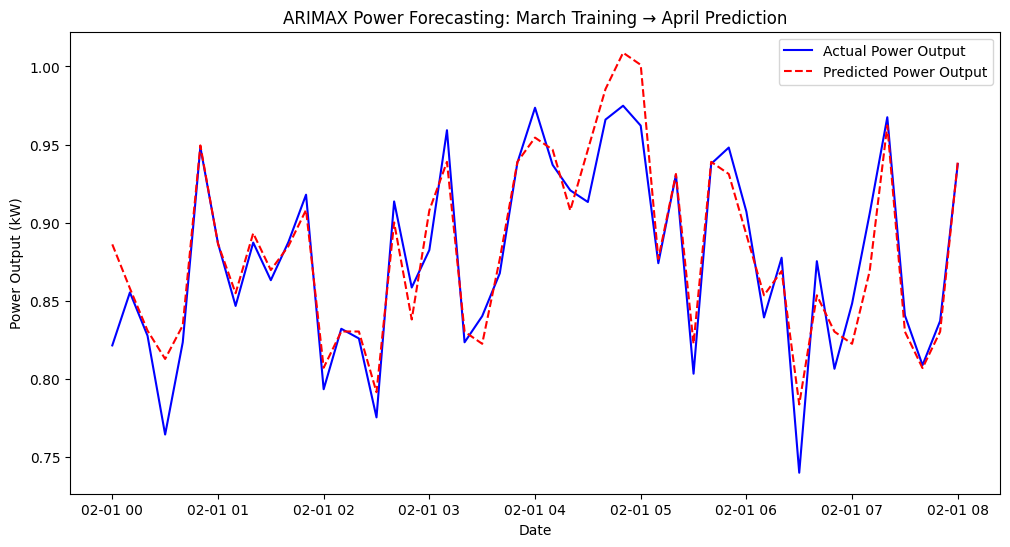

In [12]:
plt.figure(figsize=(12,6))

# Plot actual test data
plt.plot(test_y.index, test_y, label="Actual Power Output", color="blue")

# Plot predicted data
plt.plot(predictions_df.index, predictions_df['predicted_power'], label="Predicted Power Output", 
         color="red", linestyle="dashed")

plt.xlabel("Date")
plt.ylabel("Power Output (kW)")
plt.title("ARIMAX Power Forecasting: March Training → April Prediction")
plt.legend()
plt.show()


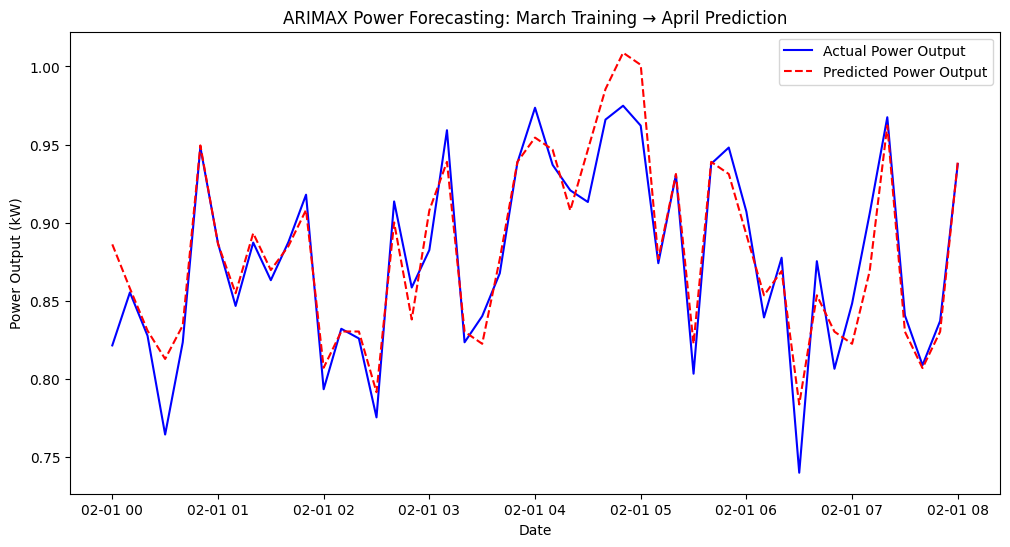

In [17]:
plt.figure(figsize=(12,6))

# Plot actual test data
plt.plot(test_y.index, test_y, label="Actual Power Output", color="blue")

# Plot predicted data
plt.plot(predictions_df.index, predictions_df['predicted_power'], label="Predicted Power Output", 
         color="red", linestyle="dashed")

plt.xlabel("Date")
plt.ylabel("Power Output (kW)")
plt.title("ARIMAX Power Forecasting: March Training → April Prediction")
plt.legend()
plt.show()


In [25]:
import pmdarima as pm
# Use auto_arima to find the best p, d, q values
auto_model = pm.auto_arima(train_y, exogenous=train_X, seasonal=False, stepwise=True, trace=True)

# Print summary of the model
print(auto_model.summary())

# Extract the best (p, d, q) values from the auto_arima model
best_p, best_d, best_q = auto_model.order
print(f"Best p: {best_p}, Best d: {best_d}, Best q: {best_q}")

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=3.08 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-11310.978, Time=0.18 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-11310.452, Time=0.35 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-11310.823, Time=0.38 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-11312.939, Time=0.12 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-11419.755, Time=1.44 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-11446.263, Time=1.64 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-11352.700, Time=0.37 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=-11444.501, Time=2.44 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-11445.634, Time=0.97 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=-11364.989, Time=0.89 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=-11403.802, Time=2.58 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=-11448.155, Time=0.56 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-11421.637, Time=0.48 sec
 ARIMA(2,1,0

In [29]:
p=2
q=1

arima_model = ARIMA(train_y, exog=train_X, order=(p, 1, q))

# Fit model
arima_fit = arima_model.fit()

# Print model summary
print(arima_fit.summary())


c:\Users\rsaxe\.conda\envs\yolov8\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 10min will be used.
  self._init_dates(dates, freq)
c:\Users\rsaxe\.conda\envs\yolov8\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 10min will be used.
  self._init_dates(dates, freq)
c:\Users\rsaxe\.conda\envs\yolov8\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 10min will be used.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:                  Power   No. Observations:                 4464
Model:                 ARIMA(2, 1, 1)   Log Likelihood                8049.782
Date:                Fri, 14 Feb 2025   AIC                         -16089.565
Time:                        11:01:46   BIC                         -16057.547
Sample:                    01-01-2020   HQIC                        -16078.278
                         - 01-31-2020                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
WindSpeed      1.4593      0.008    190.214      0.000       1.444       1.474
ar.L1          0.7806      0.023     34.165      0.000       0.736       0.825
ar.L2         -0.0626      0.009     -6.794      0.0

In [30]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
# Use actual timestamps for start and end
start_date = test_y.index[0]  # First timestamp of test data
end_date = test_y.index[-1]   # Last timestamp of test data

# Make predictions using the actual timestamps
predictions = arima_fit.predict(start=start_date, end=end_date, exog=test_X)

# Evaluate performance
mae = mean_absolute_error(test_y, predictions)
mse = mean_squared_error(test_y, predictions)
mpe = mean_absolute_percentage_error(test_y, predictions)
rmse = np.sqrt(mse)

print(f"Mean Absolute Error (MAE): {mae}")
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"mean_absolute_percentage_error: {mpe}")



Mean Absolute Error (MAE): 0.015038648473147304
Root Mean Squared Error (RMSE): 0.020490081028661025
mean_absolute_percentage_error: 0.017453687731910254


In [31]:
predictions_df = pd.DataFrame({'timestamp': test_y.index, 'predicted_power': predictions})
predictions_df.set_index('timestamp', inplace=True)
print(predictions_df.head())



                     predicted_power
timestamp                           
2020-02-01 00:00:00         0.886126
2020-02-01 00:10:00         0.857952
2020-02-01 00:20:00         0.830925
2020-02-01 00:30:00         0.812787
2020-02-01 00:40:00         0.834268


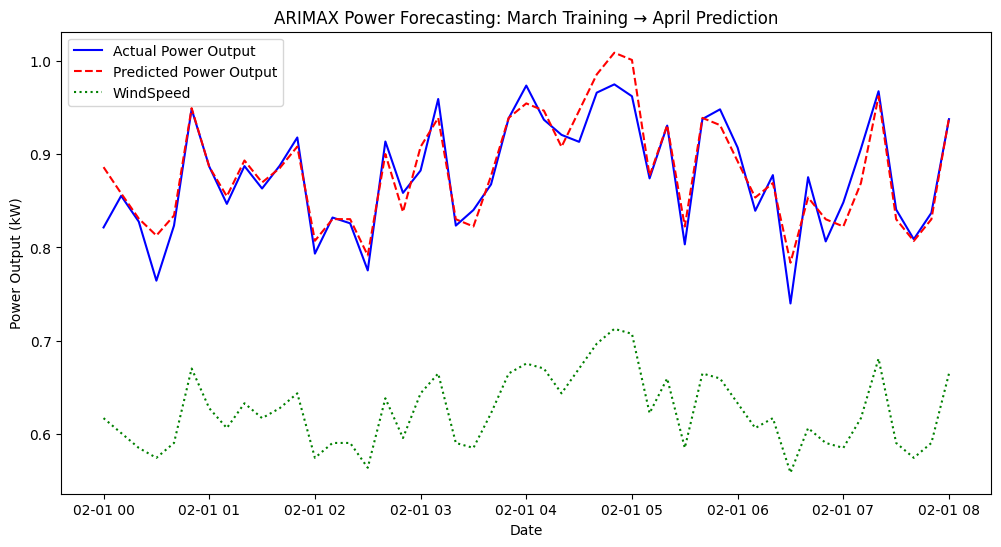

In [40]:
plt.figure(figsize=(12,6))

# Plot actual test data
plt.plot(test_y.index, test_y, label="Actual Power Output", color="blue")

# Plot predicted data
plt.plot(predictions_df.index, predictions_df['predicted_power'], label="Predicted Power Output", 
         color="red", linestyle="dashed")

plt.plot(df_wind.index, df_wind['WindSpeed'], label="WindSpeed", 
         color="green", linestyle="dotted")


plt.xlabel("Date")
plt.ylabel("Power Output (kW)")
plt.title("ARIMAX Power Forecasting: March Training → April Prediction")
plt.legend()
plt.show()


In [47]:
df_wind = df_scaled[['WindSpeed', 'Power']]

In [48]:
df_wind = df_wind.loc['2020-02-01 00:00:00':'2020-02-01 08:00:00']

In [49]:
df_wind.index

DatetimeIndex(['2020-02-01 00:00:00', '2020-02-01 00:10:00',
               '2020-02-01 00:20:00', '2020-02-01 00:30:00',
               '2020-02-01 00:40:00', '2020-02-01 00:50:00',
               '2020-02-01 01:00:00', '2020-02-01 01:10:00',
               '2020-02-01 01:20:00', '2020-02-01 01:30:00',
               '2020-02-01 01:40:00', '2020-02-01 01:50:00',
               '2020-02-01 02:00:00', '2020-02-01 02:10:00',
               '2020-02-01 02:20:00', '2020-02-01 02:30:00',
               '2020-02-01 02:40:00', '2020-02-01 02:50:00',
               '2020-02-01 03:00:00', '2020-02-01 03:10:00',
               '2020-02-01 03:20:00', '2020-02-01 03:30:00',
               '2020-02-01 03:40:00', '2020-02-01 03:50:00',
               '2020-02-01 04:00:00', '2020-02-01 04:10:00',
               '2020-02-01 04:20:00', '2020-02-01 04:30:00',
               '2020-02-01 04:40:00', '2020-02-01 04:50:00',
               '2020-02-01 05:00:00', '2020-02-01 05:10:00',
               '2020-02-

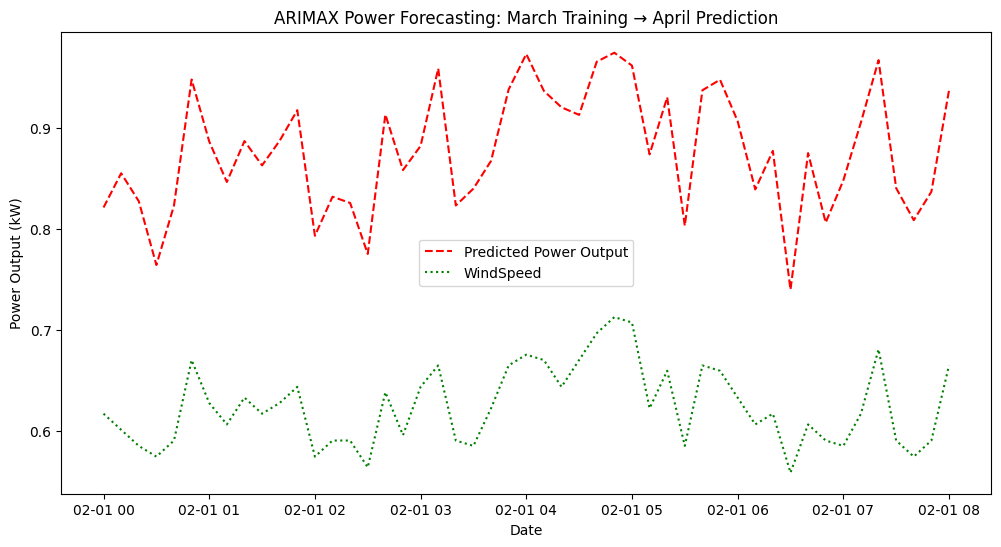

In [50]:
plt.figure(figsize=(12,6))

# # Plot actual test data
# plt.plot(test_y.index, test_y, label="Actual Power Output", color="blue")

# Plot predicted data
plt.plot(df_wind.index, df_wind['Power'], label="Predicted Power Output", 
         color="red", linestyle="dashed")

plt.plot(df_wind.index, df_wind['WindSpeed'], label="WindSpeed", 
         color="green", linestyle="dotted")


plt.xlabel("Date")
plt.ylabel("Power Output (kW)")
plt.title("ARIMAX Power Forecasting: March Training → April Prediction")
plt.legend()
plt.show()
